In [1]:
import torchvision
import torchvision.transforms as transforms
from lookahead_pytorch import Lookahead
from CIFAR.model import ResNet18
import torch 
from torch import nn 
import numpy as np 
import torchbearer

NB_EPOCHS = 200
NB_TRIALS = 3
DATASET = 'CIFAR100' # or 'CIFAR10' 

# Data setup 
if DATASET == 'CIFAR10':
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
elif DATASET == 'CIFAR100':
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
else:
    raise ValueError("Dataset not setup")


channel_means = [np.mean(trainset.data[:,:,:,i]) for i in range(3)]
channel_stds = [np.std(trainset.data[:,:,:,i]) for i in range(3)]

# Transforms
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[x / 255.0 for x in channel_means],
                        std=[x / 255.0 for x in channel_stds])])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean=[x / 255.0 for x in channel_means],
                        std=[x / 255.0 for x in channel_stds])])

if DATASET == 'CIFAR10':
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
elif DATASET == 'CIFAR100':
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)    

# Data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

device = "cuda:0"
results = []

def train(optimizer_name):
    scheduler = torchbearer.callbacks.torch_scheduler.MultiStepLR(milestones=[60, 120, 160], gamma=0.2)

    if DATASET == 'CIFAR100':
        model = ResNet18(100)
    else:
        model = ResNet18()

    checkpoint = torchbearer.callbacks.ModelCheckpoint(DATASET +  "\\" + str(trial_num) + "\\" + optimizer_name + '_checkpoint.pt')
    logger = torchbearer.callbacks.CSVLogger(DATASET + "\\" + str(trial_num) + "\\" + optimizer_name + '_log.pt', separator=',', append=True)

    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.001)
    elif optimizer_name == 'Lookahead':
        optimizer = Lookahead(torch.optim.SGD(model.parameters(), lr=0.1), la_alpha=0.8, la_steps=5)
    elif optimizer_name == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1)
    elif optimizer_name == 'Polyak':
        optimizer = torch.optim.ASGD(model.parameters(), lr=0.3, weight_decay=0.001)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters())
    elif optimizer_name == 'Lookahead(Adam)':
        optimizer = Lookahead(torch.optim.Adam(model.parameters()))
    else:
        raise ValueError("Optimizer not setup")

    loss_function = nn.CrossEntropyLoss()
    trial = torchbearer.Trial(model, optimizer, loss_function, metrics=['loss', 'accuracy', 'top_5_acc'], callbacks=[scheduler, checkpoint, logger]).to(device)
    trial.with_generators(trainloader, val_generator=valloader)
    results.append(trial.run(epochs=NB_EPOCHS))   

# Run 
optimizer_names = ['SGD', 'Lookahead', 'AdamW', 'Polyak', 'Adam', 'Lookahead(Adam)']
# optimizer_names = ['Adam', 'Lookahead(Adam)']
for trial_num in range(NB_TRIALS):
    torch.manual_seed(trial_num+1)
    for i, opt in enumerate(optimizer_names):
        train(opt)

    # Test Plot
    import matplotlib.pyplot as plt 
    import pandas as pd 

    plt.figure()
    for opt_name, result in zip(optimizer_names, results):
        plt.plot(pd.DataFrame(result)['val_loss'], label=opt_name)
        # pd.DataFrame(result).to_csv("results_"+opt_name)
    plt.grid(True)
    plt.legend()
    plt.savefig(DATASET + "\\" + str(trial_num) + '\\loss_plot.png')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


ModuleNotFoundError: No module named 'matplotlib'

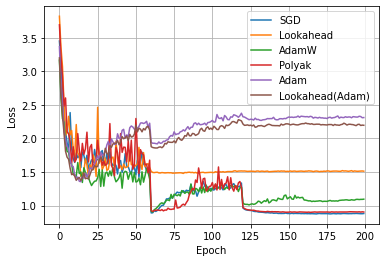

In [13]:
import matplotlib.pyplot as plt
import pandas as pd 
plt.figure()
for opt_name, result in zip(optimizer_names, results):
    plt.plot(pd.DataFrame(result)['val_loss'], label=opt_name)
    pd.DataFrame(result).to_csv(DATASET + "\\" + str(trial_num) + "\\results_"+opt_name+".csv")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.savefig(DATASET + "\\" + str(trial_num) + '\\loss_plot2.png')

In [ ]:
for trial_num in [1,2]:
    torch.manual_seed(trial_num+1)
    for i, opt in enumerate(optimizer_names):
        train(opt)

    # Test Plot
    import matplotlib.pyplot as plt 
    import pandas as pd 

    plt.figure()
    for opt_name, result in zip(optimizer_names, results):
        plt.plot(pd.DataFrame(result)['val_loss'], label=opt_name)
        pd.DataFrame(result).to_csv(DATASET + "\\" + str(trial_num) + "\\results_"+opt_name+".csv")
    plt.grid(True)
    plt.legend()
    plt.savefig(DATASET + "\\" + str(trial_num) + '\\loss_plot.png')

C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
